In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [19]:
from huggingface_hub import notebook_login

notebook_login()

In [3]:
from datasets import load_dataset

In [4]:
# import pandas as pd
# from datasets import Dataset, DatasetDict
# from PIL import Image
# import os

# # Load the CSV file
# csv_file_path = '/kaggle/input/flickr8k/captions.txt'
# images_folder_path = '/kaggle/input/flickr8k/Images'
# df = pd.read_csv('/kaggle/input/flickr8k/captions.txt')
# df['image'] = df['image'].apply(
#     lambda x: f'/kaggle/input/flickr8k/Images/{x}')
# df.head()




In [5]:
# # Function to load images
# def load_image(image_name):
#     image_path = os.path.join(images_folder_path, image)
#     return Image.open(image_path)

# Create a dictionary to store the data
# data = {
#     'image': [load_image(image) for image in df['image']],
#     'text': df['caption'].tolist()
# }

# # Create a Dataset from the dictionary
# dataset = Dataset.from_dict(data)

# # Create a DatasetDict and add the dataset as the 'train' split
# dataset_dict = DatasetDict({
#     'train': dataset
# })

# # Display the dataset
# print(dataset_dict)

In [6]:
import pandas as pd
from datasets import Dataset, DatasetDict
from PIL import Image
import os

# Load the CSV file
csv_file_path = '/kaggle/input/flickr8k/captions.txt'
images_folder_path = '/kaggle/input/flickr8k/Images'
df = pd.read_csv(csv_file_path)

# Update the image paths in the DataFrame
df['image'] = df['image'].apply(lambda x: os.path.join(images_folder_path, x))

# Function to load images
def load_image(image_path):
    return Image.open(image_path)

# Create a dictionary to store the data
data = {
    'image': [load_image(image) for image in df['image']],
    'text': df['caption'].tolist()
}

# Create a Dataset from the dictionary
dataset = Dataset.from_dict(data)

# Create a DatasetDict and add the dataset as the 'train' split
dataset_dict = DatasetDict({
    'train': dataset
})

# Display the dataset
print(dataset_dict)


DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 40455
    })
})


In [7]:
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 40455
    })
})

In [8]:
ds = dataset_dict["train"].train_test_split(test_size=0.1)
train_ds = ds["train"]
test_ds = ds["test"]

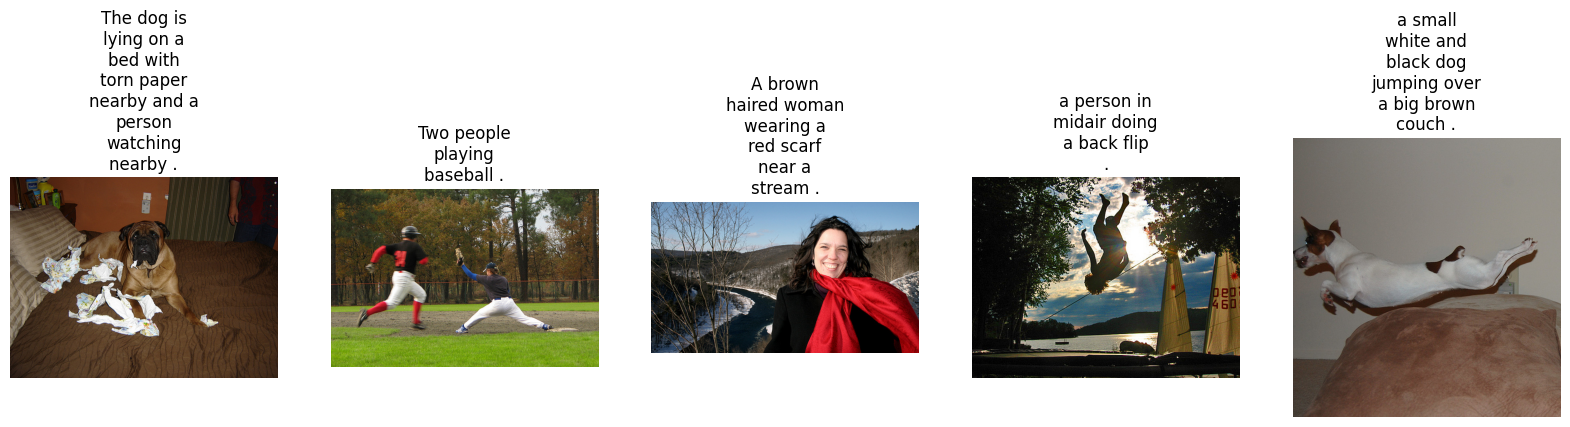

In [9]:
from textwrap import wrap
import matplotlib.pyplot as plt
import numpy as np


def plot_images(images, captions):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        caption = captions[i]
        caption = "\n".join(wrap(caption, 12))
        plt.title(caption)
        plt.imshow(images[i])
        plt.axis("off")


sample_images_to_visualize = [np.array(train_ds[i]["image"]) for i in range(5)]
sample_captions = [train_ds[i]["text"] for i in range(5)]
plot_images(sample_images_to_visualize, sample_captions)

In [10]:
from transformers import AutoProcessor

checkpoint = "microsoft/git-base"
processor = AutoProcessor.from_pretrained(checkpoint)

2024-06-03 01:27:34.746781: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-03 01:27:34.746904: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-03 01:27:34.854587: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


preprocessor_config.json:   0%|          | 0.00/503 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/453 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [11]:
def transforms(example_batch):
    images = [x for x in example_batch["image"]]
    captions = [x for x in example_batch["text"]]
    inputs = processor(images=images, text=captions, padding="max_length")
    inputs.update({"labels": inputs["input_ids"]})
    return inputs


train_ds.set_transform(transforms)
test_ds.set_transform(transforms)

In [12]:
# !pip install transformers datasets evaluate -q


In [13]:
from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained(checkpoint)

config.json:   0%|          | 0.00/2.82k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/707M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

In [14]:
try:
    import evaluate
    print("evaluate package is already installed.")
except ImportError:
    print("evaluate package is not installed.")


evaluate package is not installed.


In [15]:
# %pip install evaluate


In [16]:
# from evaluate import load
# import torch

# wer = load("wer")


# def compute_metrics(eval_pred):
#     logits, labels = eval_pred
#     predicted = logits.argmax(-1)
#     decoded_labels = processor.batch_decode(labels, skip_special_tokens=True)
#     decoded_predictions = processor.batch_decode(predicted, skip_special_tokens=True)
#     wer_score = wer.compute(predictions=decoded_predictions, references=decoded_labels)
#     return {"wer_score": wer_score}

In [30]:
from transformers import TrainingArguments, Trainer

model_name = checkpoint.split("/")[1]

training_args = TrainingArguments(
    output_dir=f"{model_name}-pokemon",
    learning_rate=5e-5,
    num_train_epochs=1,
    fp16=True,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=2,
    save_total_limit=3,
    eval_strategy="steps",
    eval_steps=2000,
    save_strategy="steps",
    save_steps=2000,
    logging_steps=2000,
    remove_unused_columns=False,
    push_to_hub=True,
    label_names=["labels"],
    load_best_model_at_end=True,
)


In [31]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
#     compute_metrics=compute_metrics,
)

In [32]:
import torch
torch.cuda.empty_cache()
trainer.train()

Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Step,Training Loss,Validation Loss
2000,0.076200,0.074016
4000,0.073500,0.071095
6000,0.071200,0.069086
8000,0.069300,0.067101


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


TrainOutput(global_step=9102, training_loss=0.07188740836947967, metrics={'train_runtime': 4966.8863, 'train_samples_per_second': 7.33, 'train_steps_per_second': 1.833, 'total_flos': 1.7027389477896192e+16, 'train_loss': 0.07188740836947967, 'epoch': 0.9999450700357044})

In [33]:
trainer.push_to_hub()


events.out.tfevents.1717379882.d8035f84e3f7.34.3:   0%|          | 0.00/7.33k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Prabesh06/git-base-pokemon/commit/32c43e1abf9f20b38bf7813e50059bc4af5f166f', commit_message='End of training', commit_description='', oid='32c43e1abf9f20b38bf7813e50059bc4af5f166f', pr_url=None, pr_revision=None, pr_num=None)

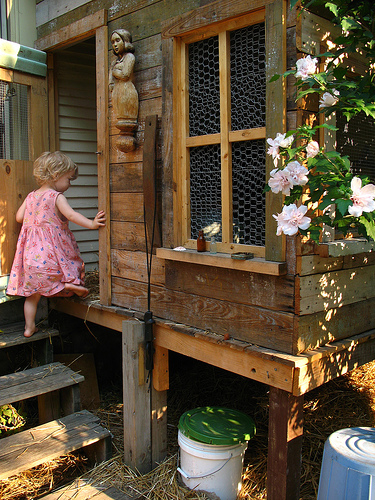

In [46]:
from PIL import Image
import requests

# url = "https://huggingface.co/datasets/sayakpaul/sample-datasets/resolve/main/pokemon.png"
# image = Image.open(requests.get(url, stream=True).raw)
image_path  = '/kaggle/input/flickr8k/Images/1000268201_693b08cb0e.jpg'
image=Image.open(image_path)
image

In [47]:
device = "cuda" if torch.cuda.is_available() else "cpu"

inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

In [48]:
generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
generated_caption

'a man in a black shirt and a woman in a white dress and a woman in a black coat.'

In [45]:
generated_caption

'a man is standing on a rocky shore with a mountain in the background.'